In [1]:
!pip install transformers peft accelerate bitsandbytes \
    -U --no-index --find-links /kaggle/input/lmsys-wheel-files

Looking in links: /kaggle/input/lmsys-wheel-files
Processing /kaggle/input/lmsys-wheel-files/peft-0.11.1-py3-none-any.whl
Processing /kaggle/input/lmsys-wheel-files/bitsandbytes-0.43.1-py3-none-manylinux_2_24_x86_64.whl


In [2]:
import time
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor

import torch
import sklearn
import numpy as np
import pandas as pd
from transformers import Gemma2ForSequenceClassification, GemmaTokenizerFast, BitsAndBytesConfig
from transformers.data.data_collator import pad_without_fast_tokenizer_warning
from peft import PeftModel

2025-09-15 17:09:33.373086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-15 17:09:33.373255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-15 17:09:33.619470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
assert torch.cuda.device_count() == 2

In [4]:
@dataclass
class Config:
    gemma_dir = '/kaggle/input/16th-place-quantize-2-of-3/merged-v159-4bit'
    max_length = 3072
    batch_size = 2
    device = torch.device("cuda")    
    tta = True  # test time augmentation. <prompt>-<model-b's response>-<model-a's response>
    spread_max_length = False  # whether to apply max_length//3 on each input or max_length on the concatenated input

cfg = Config()

In [5]:
test = pd.read_parquet('/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet')

In [6]:
display(test.head(5))

,id,prompt,response_a,response_b,scored
0,327228,Caso Clínico: Un hombre de 70 años con anteced...,**Diagnóstico Diferencial de Anemia en Pacient...,"Basándonos en el caso clínico presentado, pode...",False
1,1139415,Peel Company received a cash dividend from a ...,The correct answer is **(a) No No**. Here's ...,The correct answer is **(a) No No**. Here's wh...,False
2,1235630,Há um grave problema com o relógio da torre da...,Dois problemas interessantes!\n\n**Problema 1:...,Vamos resolver os dois problemas em sequência....,False


In [7]:
def tokenize(
    tokenizer, prompt, response_a, response_b, max_length=cfg.max_length, spread_max_length=cfg.spread_max_length
):

    text = []
    for pp,aa,bb in zip(prompt,response_a,response_b):
        
        tmp = (
            f"<start_of_turn>prompt\n{pp}<end_of_turn>\n"
            + f"<start_of_turn>response_a\n{aa}<end_of_turn>\n"
            + f"<start_of_turn>response_b\n{bb}<end_of_turn>"
        )
        
        if len(tokenizer(tmp)["input_ids"]) >= max_length:
            tmp = (
            f"<start_of_turn>prompt\n{pp[-(max_length // 3):]}<end_of_turn>\n"
            + f"<start_of_turn>response_a\n{aa[-(max_length // 3):]}<end_of_turn>\n"
            + f"<start_of_turn>response_b\n{bb[-(max_length // 3):]}<end_of_turn>"
        ) # modify the three text len to fit the length limitation
        text.append( tmp )

    tokenized = tokenizer(text, max_length=max_length, truncation=True, padding=False)
    input_ids = tokenized.input_ids
    attention_mask = tokenized.attention_mask
    return input_ids, attention_mask

In [8]:
%%time

tokenizer = GemmaTokenizerFast.from_pretrained(cfg.gemma_dir)
tokenizer.add_eos_token = True
tokenizer.padding_side = "right"

data = pd.DataFrame()
data["id"] = test["id"]
data["input_ids"], data["attention_mask"] = tokenize(tokenizer, test["prompt"], test["response_a"], test["response_b"])
data["length"] = data["input_ids"].apply(len)

aug_data = pd.DataFrame()
aug_data["id"] = test["id"]
# swap response_a & response_b
aug_data['input_ids'], aug_data['attention_mask'] = tokenize(tokenizer, test["prompt"], test["response_b"], test["response_a"])
aug_data["length"] = aug_data["input_ids"].apply(len)

CPU times: user 861 ms, sys: 174 ms, total: 1.03 s
Wall time: 1.21 s


In [9]:
print(tokenizer.decode(data["input_ids"][1]))

<bos><start_of_turn>prompt
 Peel Company received a cash dividend from a common stock investment. Should Peel report an increase in the investment account if it carries the investment at fair value or if it uses the equity method of accounting?

 	Fair Value	Equity
a.	No	No
b.	Yes	Yes
c.	Yes	No
d.	No	Yes<end_of_turn>
<start_of_turn>response_a
The correct answer is **(a) No   No**. Here's why:

* **Fair Value Method:** Under the fair value method, dividends are treated as income and do not increase the investment account.  The investment itself is regularly adjusted to reflect its market value.  Dividends are considered a realization of the investment's return.

* **Equity Method:** Under the equity method, the investment account is adjusted to reflect the investor's share of the investee's net income or loss. Dividends received actually *decrease* the investment account. This is because the dividends represent a distribution of the investee's profits, which the investor has already rec

In [10]:
print(tokenizer.decode(aug_data["input_ids"][0]))

<bos><start_of_turn>prompt
Caso Clínico: Un hombre de 70 años con antecedentes de cáncer testicular tratado en 1990 y cáncer gástrico tratado en 2020, es diagnosticado con leucemia mieloide aguda (LMA). El paciente inicia tratamiento con quimioterapia (12 sesiones planificadas) y se presenta en la consulta después de la primera sesión con síntomas de fatiga intensa, disnea leve, palpitaciones y mareos. Los estudios de laboratorio revelan una hemoglobina de 8 g/dL, leucocitos bajos, y plaquetas en el límite inferior de lo normal.

El paciente refiere no haber tenido sangrados visibles, pero menciona sentirse más cansado de lo habitual desde el inicio del tratamiento. No tiene fiebre ni signos de infección activa.

Pregunta:

Con base en el cuadro clínico descrito, proponga un diagnóstico diferencial que incluya al menos tres posibles causas de la anemia en este paciente.<end_of_turn>
<start_of_turn>response_a
Basándonos en el caso clínico presentado, podemos proponer un diagnóstico dife

In [11]:
# Load base model on GPU 0
device_0 = torch.device('cuda:0')
model_0 = Gemma2ForSequenceClassification.from_pretrained(
    cfg.gemma_dir,
    device_map=device_0,
    use_cache=False,
)

# Load base model on GPU 1
device_1 = torch.device('cuda:1')
model_1 = Gemma2ForSequenceClassification.from_pretrained(
    cfg.gemma_dir,
    device_map=device_1,
    use_cache=False,
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
@torch.no_grad()
@torch.cuda.amp.autocast()
def inference(df, model, device, batch_size=cfg.batch_size, max_length=cfg.max_length):
    # a_win, b_win, tie = [], [], []
    a_win, b_win = [], []
    
    for start_idx in range(0, len(df), batch_size):
        end_idx = min(start_idx + batch_size, len(df))
        tmp = df.iloc[start_idx:end_idx]
        input_ids = tmp["input_ids"].to_list()
        attention_mask = tmp["attention_mask"].to_list()
        inputs = pad_without_fast_tokenizer_warning(
            tokenizer,
            {"input_ids": input_ids, "attention_mask": attention_mask},
            padding="longest",
            pad_to_multiple_of=None,
            return_tensors="pt",
        )
        outputs = model(**inputs.to(device))
        proba = outputs.logits.softmax(-1).cpu()
        
        a_win.extend(proba[:, 0].tolist())
        b_win.extend(proba[:, 1].tolist())
        # tie.extend(proba[:, 2].tolist())
    
    df["winner_model_a"] = a_win
    df["winner_model_b"] = b_win
    # df["winner_tie"] = tie
    
    return df

In [13]:
st = time.time()

# sort by input length to fully leverage dynaminc padding
data = data.sort_values("length", ascending=False)
# the total #tokens in sub_1 and sub_2 should be more or less the same
sub_1 = data.iloc[0::2].copy()
sub_2 = data.iloc[1::2].copy()

with ThreadPoolExecutor(max_workers=2) as executor:
    results = executor.map(inference, (sub_1, sub_2), (model_0, model_1), (device_0, device_1))

result_df = pd.concat(list(results), axis=0)
proba = result_df[["winner_model_a", "winner_model_b"]].values

print(f"elapsed time: {time.time() - st}")
#elapsed time: 4.2011353969573975

elapsed time: 4.3264570236206055


In [14]:
st = time.time()

if cfg.tta:
    data = aug_data.sort_values("length", ascending=False)  # sort by input length to boost speed
    sub_1 = data.iloc[0::2].copy()
    sub_2 = data.iloc[1::2].copy()

    with ThreadPoolExecutor(max_workers=2) as executor:
        results = executor.map(inference, (sub_1, sub_2), (model_0, model_1), (device_0, device_1))

    tta_result_df = pd.concat(list(results), axis=0)
    # recall TTA's order is flipped
    tta_proba = tta_result_df[["winner_model_b", "winner_model_a"]].values 
    # average original result and TTA result.
    proba = (proba + tta_proba) / 2

print(f"elapsed time: {time.time() - st}")
#elapsed time: 3.4222445487976074

elapsed time: 3.4984822273254395


In [15]:
result_df.loc[:, "winner_model_a"] = proba[:, 0]
result_df.loc[:, "winner_model_b"] = proba[:, 1]
# result_df.loc[:, "winner_tie"] = proba[:, 2]
# submission_df = result_df[["id", 'winner_model_a', 'winner_model_b']]
# submission_df.to_csv('submission.csv', index=False)
# display(submission_df)
submission_df = result_df[["id", "winner_model_a"]].copy()
submission_df.rename(columns={"winner_model_a": "winner"}, inplace=True)
submission_df['winner'] = np.where(submission_df['winner'] > 0.5, 'model_a', 'model_b')
submission_df.to_csv('submission.csv', index=False)
display(submission_df)

,id,winner
0,327228,model_b
1,1139415,model_a
2,1235630,model_a


,id,predicted_winner
0,327228,model_b
1,1139415,model_a
2,1235630,model_a


## Model Accuracy ##

Accuracy: 0.3333 (1/3 correct)

## Classification Report ##

              precision    recall  f1-score   support

     model_a       0.50      0.50      0.50         2
     model_b       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3

## Confusion Matrix ##



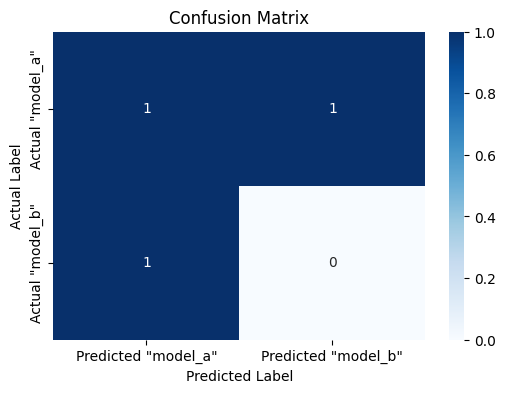

In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. GET YOUR PREDICTIONS (This comes from your notebook's last cell)
# Your notebook already generates `submission_df` with columns ['id', 'winner']
# Let's rename the 'winner' column to 'predicted_winner' for clarity.
predictions_df = submission_df.rename(columns={'winner': 'predicted_winner'})
display(predictions_df.head())

# 2. LOAD GROUND TRUTH (This is the file you would create from your training data)
# --- This is a DUMMY example. You must replace this with your actual validation file. ---
# For this example, we'll use the 3 IDs from your test.head() output
# and create a fake set of "true" answers.
dummy_truth_data = {
    'id': [327228, 1139415, 1235630],
    'true_winner': ['model_a', 'model_a', 'model_b']  # I just made these up
}
validation_df = pd.DataFrame(dummy_truth_data)
# -------------------------------------------------------------------------------------

# 3. MERGE PREDICTIONS AND TRUTH
# We merge to align the predicted winner with the true winner for each id.
# 'inner' merge ensures we only score items present in both dataframes.
merged_df = pd.merge(predictions_df, validation_df, on='id', how='inner')

if merged_df.empty:
    print("No matching IDs found between predictions and validation set.")
    print("Please check your dummy/real validation data.")
else:
    # 4. CALCULATE METRICS
    y_pred = merged_df['predicted_winner']
    y_true = merged_df['true_winner']

    # Calculate Accuracy
    # Accuracy = (Total Correct Predictions) / (Total Predictions)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"## Model Accuracy ##\n")
    print(f"Accuracy: {accuracy:.4f} ({merged_df['predicted_winner'].eq(merged_df['true_winner']).sum()}/{len(merged_df)} correct)\n")

    # Calculate Precision, Recall, and F1-Score
    # This report gives you precision for both 'model_a' and 'model_b'
    print(f"## Classification Report ##\n")
    report = classification_report(y_true, y_pred, labels=['model_a', 'model_b'])
    print(report)

    # Optional: Display a Confusion Matrix
    print(f"## Confusion Matrix ##\n")
    cm = confusion_matrix(y_true, y_pred, labels=['model_a', 'model_b'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted "model_a"', 'Predicted "model_b"'], 
                yticklabels=['Actual "model_a"', 'Actual "model_b"'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()